In [1]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz
%load_ext line_profiler

from coeditor.common import *
import os
from coeditor.model import RetrievalEditorModel, AttentionMode, DecodingArgs, EditCostModel, MultiRoundEvaluator
from coeditor.service import EditPredictionService, ChangeDetector
from coeditor.c3problem import C3GeneratorCache, C3Problem, C3ProblemTokenizer

os.chdir(proj_root())

In [2]:
# target_dir = proj_root() / "../SPOT-copy/"
target_dir = proj_root()
model_name = "coeditor-xl-c3-dropout-v1.6-resumed"
model_path = get_model_dir(True) / model_name
model = RetrievalEditorModel.load(model_path)
model.to("cuda:2")
pass

In [3]:
testset: list[C3Problem] = pickle_load(
    get_dataset_dir("xl")
    / "transformed"
    / "C3ProblemGenerator(VERSION=2.9)-C3ProblemChangeDropout(VERSION=1.3)"
)["test"]
len(testset)


1489

In [4]:
subset = list[C3Problem]()
for ex in tqdm(testset):
    ex = ex.restrict_span_changes()
    c = ex.span.get_change()
    if len(c.before) <= 6000 and len(c.after) <= 6000:
        subset.append(ex)


100%|██████████| 1489/1489 [00:01<00:00, 1212.66it/s]


In [5]:
cm = EditCostModel()
subset = subset[0:-1:10]
all_costs = pmap(
    cm.get_edit_gain,
    [ex.span.original.tolist() for ex in subset],
    [ex.span.delta for ex in subset],
)
scalar_stats(all_costs)

pmap: get_edit_gain: 100%|██████████| 148/148 [00:01<00:00, 111.37it/s]


{'mean': 74.12837837837837, 'median': 38.5, 'min': 5, 'max': 617}

(array([28., 26., 18., 18., 13.,  7.,  4.,  3.,  4.,  2.,  3.,  1.,  2.,
         1.,  2.,  2.,  1.,  0.,  2.,  3.,  0.,  1.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,
         0.]),
 array([  0. ,  12.5,  25. ,  37.5,  50. ,  62.5,  75. ,  87.5, 100. ,
        112.5, 125. , 137.5, 150. , 162.5, 175. , 187.5, 200. , 212.5,
        225. , 237.5, 250. , 262.5, 275. , 287.5, 300. , 312.5, 325. ,
        337.5, 350. , 362.5, 375. , 387.5, 400. , 412.5, 425. , 437.5,
        450. , 462.5, 475. , 487.5, 500. ]),
 <BarContainer object of 40 artists>)

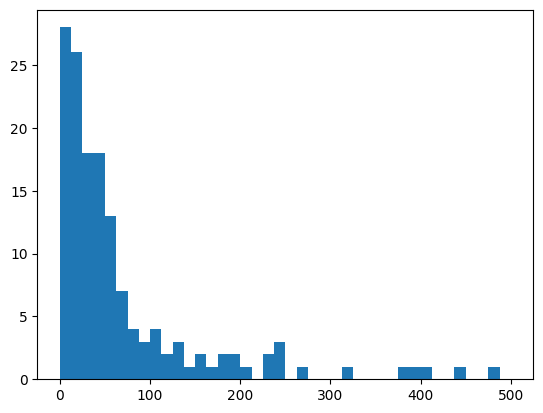

In [6]:
# plot a histogram of the costs
import matplotlib.pyplot as plt

plt.hist(all_costs, bins=40, range=(0, 500))


In [7]:
subset = [ex for i, ex in enumerate(subset) if 50 <= all_costs[i] <= 500]
len(subset)


57

cm = EditCostModel()
%timeit -n 1 -r 3 all_costs = [cm.get_edit_gain(ex.span.original.tolist(), ex.span.delta) for ex in tqdm(testset[:50])]

In [10]:
tokenizer = C3ProblemTokenizer(
    max_query_tks=1024,
    max_ref_tks=1024,
    max_output_tks=512,
    max_ref_tks_sum=1024 * 12,
)
dec_args = DecodingArgs(do_sample=False, num_beams=1, length_penalty=0.0)

# %lprun -f -u 0.001 RetrievalEditorModel.multi_round_edit_gain
evaluator = MultiRoundEvaluator(model, tokenizer, dec_args, strategy="least_effort")
multi_stats = [
    evaluator.multi_round_edit_gain(ex, print_steps=False)
    for ex in tqdm(subset, smoothing=0.0)
]


100%|██████████| 57/57 [02:21<00:00,  2.48s/it]


In [11]:
keys = ["label_edit_gain", "first_edit_gain", "total_edit_gain", "rounds"]
stats = {k: scalar_stats([getattr(s, k) for s in multi_stats]) for k in keys}   
pretty_print_dict(stats)

print(f"For all edits (n={len(multi_stats)}):")
label_sum = sum(s.label_edit_gain for s in multi_stats)
single_sum = sum(s.first_edit_gain for s in multi_stats)
multi_sum = sum(s.total_edit_gain for s in multi_stats)
print(f"Single-round Gain ratio: {single_sum / label_sum:.2%}")
print(f"Multi-round Gain ratio: {multi_sum / label_sum:.2%}")

big_stats = [s for s in multi_stats if 100 <= s.label_edit_gain]
print(f"For big edits (n={len(big_stats)}):")
label_sum = sum(s.label_edit_gain for s in big_stats)
single_sum = sum(s.first_edit_gain for s in big_stats)
multi_sum = sum(s.total_edit_gain for s in big_stats)
print(f"Single-round Gain ratio: {single_sum / label_sum:.2%}")
print(f"Multi-round Gain ratio: {multi_sum / label_sum:.2%}")

label_edit_gain:
   mean: 146.4
   median: 102
   min: 51
   max: 487
first_edit_gain:
   mean: 45.088
   median: 4
   min: 0
   max: 487
total_edit_gain:
   mean: 48.789
   median: 21
   min: -45
   max: 487
rounds:
   mean: 2.7544
   median: 2
   min: 1
   max: 8
For all edits (n=57):
Single-round Gain ratio: 30.80%
Multi-round Gain ratio: 33.33%
For big edits (n=30):
Single-round Gain ratio: 30.32%
Multi-round Gain ratio: 31.12%


In [10]:
# find the first index where the edit gain is less than 0
ex_id = next(i for i, s in enumerate(multi_stats) if s.total_edit_gain < 0)
ex = subset[ex_id]
ex.print()

--------------------------------------------------------------------------------
summary:
path: gym.envs.classic_control.rendering/SimpleImageViewer.close
project: gym
commit: CommitInfo(hash='12e8b763d5dcda4962cbd17887d545f0eec6808a', parents=('01a381669bc8129545ac347cf3b7f9346f6ff898',), msg='a few minor changes: (#1250)')
--------------------------------------------------------------------------------
main change:
<add>         if self.isopen and sys.meta_path:
 <add>             # ^^^ check sys.meta_path to avoid 'ImportError: sys.meta_path is None, Python is likely shutting down'
 <del>         if self.isopen:
            self.window.close()
            self.isopen = False

--------------------------------------------------------------------------------
edit_line_ids:
range(0, 4)


In [11]:
evaluator.multi_round_edit_gain(ex, print_steps=True)

--------------------------------------------------------------------------------
gold_change:
Modified: 
  +         if self.isopen and sys.meta_path:
  +             # ^^^ check sys.meta_path to avoid 'ImportError: sys.meta_path is None, Python is likely shutting down'
  -         if self.isopen:
                self.window.close()
                self.isopen = False
 
Remaining changes:
TkDelta(
  0: ('<add>         if self.isopen and sys.meta_path:', "<add>             # ^^^ check sys.meta_path to avoid 'ImportError: sys.meta_path is None, Python is likely shutting down'", '<del>')
)
replace lines: (0,1) -> (0,2), cost=139
  -         if self.isopen:
  +         if self.isopen and sys.meta_path:
  +             # ^^^ check sys.meta_path to avoid 'ImportError: sys.meta_path is None, Python is likely shutting down'
total cost: 139
--------------------------------------------------------------------------------
round:
1
------------------------------------------------------------------

MultiRoundEditStats(label_edit_gain=139, first_edit_gain=0, total_edit_gain=-23, rounds=2)